In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

In [2]:
df1 = pd.read_csv('data_01.csv')
df2 = pd.read_csv('data_02.csv')
df3 = pd.read_csv('data_03.csv')
df4 = pd.read_csv('data_04.csv')
df5 = pd.read_csv('data_05.csv')
df6 = pd.read_csv('data_06.csv')

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       55 non-null     float64
 1   y       55 non-null     float64
dtypes: float64(2)
memory usage: 1012.0 bytes


/Users/imachome/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/imachome/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/imachome/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/imachome/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

<Axes: xlabel='x', ylabel='y'>

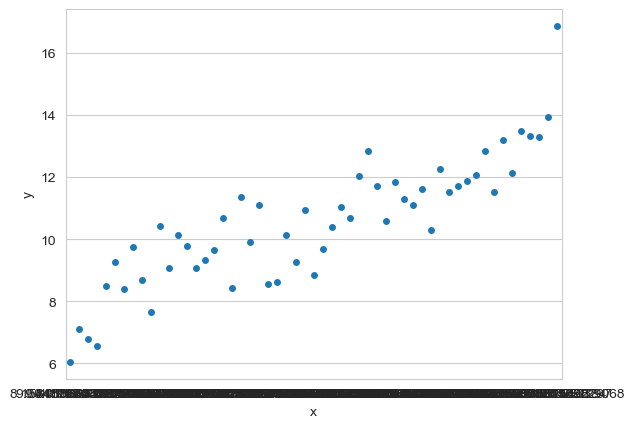

In [4]:
sns.stripplot(x="x", y="y", data=df1, jitter=True)

In [5]:
print(len(df1))
print(len(df2))
print(len(df3))
print(len(df4))
print(len(df5))

55
50
55
53
47


In [6]:
df = pd.concat([df1, df2, df3, df4, df5, df6])

In [7]:
lens = [len(df1), len(df2), len(df3), len(df4), len(df5), len(df6)]
N = 47
idx = np.repeat(0, len(df1))
idx = np.append(idx, np.repeat(1, len(df2)))
idx = np.append(idx, np.repeat(2, len(df3)))
idx = np.append(idx, np.repeat(3, len(df4)))
idx = np.append(idx, np.repeat(4, len(df5)))
idx = np.append(idx, [5, 5])

np.random.seed(43)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

x_m = df['x']
y_m = df['y']

_, ax = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for l in lens:
  for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += l
    k += l
plt.tight_layout()

NameError: name 'M' is not defined

In [ ]:
M = 6
x = df['x']
y = df['y']
x_centered = x - x.mean()

with pm.Model() as model:
  α_tmp = pm.Normal('α_tmp', mu=0, sigma=10, shape=M)
  β = pm.Normal('β', mu=0, sigma=10, shape=M)
  ε = pm.HalfCauchy('ε', 5)
  ν = pm.Exponential('ν', 1/30)

  y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
  sigma=ε, nu=ν, observed=y)
  α = pm.Deterministic('α', α_tmp - β * x.mean())

  trace_1 = pm.sample(2000, idata_kwargs={"log_likelihood": True})
  az.plot_forest(trace_1, var_names=['α', 'β'], combined=True);

In [ ]:
az.summary(trace_1)

In [ ]:


with pm.Model() as hierarchical_model:
    # априорные гипер-распределения
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=11)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=11)
    β_μ = pm.Normal('β_μ', mu=0, sigma=1)
    β_σ = pm.HalfNormal('β_σ', sigma=1)

    # априорные распеределения
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    # апосториорное распределение
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sigma=ε, nu=ν, observed=y)

    # обратное перемасштабирование
    α = pm.Deterministic('α', α_tmp - β * x.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x.mean())

    # трассировка
    trace_hm = pm.sample(3000,tune = 1000) #target_accept=.8

az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);

In [ ]:
az.summary(trace_hm)


In [ ]:
len(df1)

In [ ]:

_, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True, constrained_layout=True)
trace_11 = trace_1.posterior.stack(samples={"chain", "draw"})
trace_hmm = trace_hm.posterior.stack(samples={"chain", "draw"})


ax = np.ravel(ax)
j, k = 0, lens[0]
x_range = np.linspace(x_m.min(), x_m.max(), 10)

for i in range(M):
  try:
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hmm['α'].sel({'α_dim_0':i}).mean().item()
    beta_m  = trace_hmm['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='r',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x'+' - иерахич. модель')

    alpha_o = trace_11['α'].sel({'α_dim_0':i}).mean().item()
    beta_o = trace_11['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_o + beta_o * x_range, 'g--',
               label=f'y = {alpha_o:.2f} + {beta_o:.2f} * x'+' - неиерахич. модель')

    ax[i].legend()
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += lens[i]
    k += lens[i+1]
  except Exception as e:
    pass

In [ ]:
loo = az.loo(trace_1)
waic = az.waic(trace_1)

In [ ]:
loo

In [ ]:
waic